# Trabalho de TABD

## Carregar as bibliotecas necessárias

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import psycopg2
import math
from matplotlib.animation import FuncAnimation
import datetime
import csv
from postgis import Polygon,MultiPolygon
from postgis.psycopg import register
import trab_functions as aux
from matplotlib import cm
import time
from importlib import reload

### Definição de variáveis globais e carregar alguns ficheiros

In [40]:
starttime=time.time()

""" Definição de algumas variáveis globais """
ON_THE_FLY=False
DEBUG=True
OFFSETS=[]
OFFSETS_CSV='offsets3.csv'
EPIDEMIC_CSV='epidemic.csv'
DB_NAME='tracks'
DB_USER='nan'


""" Estabelecer uma conexão com a base de dados"""
conn = psycopg2.connect("dbname=%s user=%s" % (DB_NAME,DB_USER))
register(conn)
cursor_psql = conn.cursor()

""" Carregar o csv com os offsets """
OFFSETS = aux.read_offsets(OFFSETS_CSV)

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 17.978215 seconds


## Parte 1 - Animar uma simulação criada à priori

### Carregar o csv com a epidemia e calcular os histogramas

In [41]:
starttime=time.time()

""" Ler os dados da epidemia para um array"""
infected= aux.read_csv('epidemic.csv')
infected=np.array(infected)

""" Calcular os histogramas para as diferentes janelas temporais """
histx,histy,histy_ninf = aux.getHistogramData(infected)

if DEBUG: print("took %f seconds" % (time.time()-starttime))

[0, 0]
[0, 0]
[0, 0]
[1600, 1600]
took 39.901695 seconds


In [66]:
#todo mudar isto para o modulo trab_functions
def within(point):
    sql='''
    SELECT concelho FROM cont_aad_caop2018
    WHERE st_within(ST_SetSRID( ST_Point( %f, %f), 3763), proj_boundary)
    ''' % (point[0],point[1])
    cursor_psql.execute(sql)
    results = cursor_psql.fetchall()
    if (not results):
        return "OTHER"
    return str(results[0][0])

hora=0
concelho={}
n_rows=len(OFFSETS)
n_cols=len(OFFSETS[0])
step = int(n_rows/24)
for r in range(0,n_rows,step):
    concelho[hora]=[]
    for c in range(0,n_cols):
        if(OFFSETS[r][c][0]!=0):
            if(infected[r][c]==.2):
                name_concelho=within(OFFSETS[r][c])
                found=False
                for j in range(0,len(concelho[hora])):
                    if(concelho[hora][j][0]==name_concelho):
                        concelho[hora][j][1]+=1
                        found=True
                        break
                if(not found):
                    concelho[hora].append([name_concelho,1])
    print(hora, concelho[hora])
    r+=int(n_rows/24)
    hora+=1

## filtrar os casos no porto, lisboa e outros
n_porto=[]
n_lisboa=[]
n_others=[]
for hora in concelho:
    count=0
    for c in concelho[hora]:
        if(c[0]=='PORTO'):
            for j in range(0,359):
                n_porto.append(c[1])
        elif(c[0]=='LISBOA'):
            for j in range(0,359):
                n_lisboa.append(c[1])
        else:
            count+=1
    for j in range(0,360):
        n_others.append(count)
    
 #   n_others.append(count)
 
n_porto = np.array(n_porto)
n_lisboa = np.array(n_lisboa)

x_horas=np.array([])
for h in range(0,24):
    tmp=np.linspace(h,h,360)
    x_horas = np.concatenate((x_horas,tmp),axis=None)
print(n_porto)
print(n_lisboa)
print(n_others)

0 []
1 []
2 [['MAIA', 1], ['LISBOA', 2]]
3 [['LISBOA', 11], ['AMADORA', 1]]
4 [['PORTO', 1], ['LISBOA', 36], ['ODIVELAS', 2], ['SINTRA', 1]]
5 [['PORTO', 1], ['ODIVELAS', 3], ['OEIRAS', 2], ['AMADORA', 2], ['LISBOA', 62], ['SINTRA', 5], ['VILA FRANCA DE XIRA', 1]]
6 [['PORTO', 1], ['LOURES', 2], ['LISBOA', 82], ['ODIVELAS', 5], ['OEIRAS', 6], ['SINTRA', 5], ['AMADORA', 6], ['VILA FRANCA DE XIRA', 1]]
7 [['LISBOA', 180], ['ODIVELAS', 25], ['LOURES', 13], ['OEIRAS', 8], ['AMADORA', 6], ['SINTRA', 30], ['CASCAIS', 1], ['VILA FRANCA DE XIRA', 1]]
8 [['PORTO', 10], ['VILA NOVA DE GAIA', 5], ['ODIVELAS', 32], ['LOURES', 21], ['LISBOA', 271], ['AMADORA', 16], ['LOURINHÃ', 1], ['OEIRAS', 38], ['SINTRA', 62], ['CASCAIS', 4], ['SEIXAL', 1], ['VILA FRANCA DE XIRA', 1]]
9 [['PORTO', 142], ['MAIA', 13], ['MATOSINHOS', 28], ['VILA NOVA DE GAIA', 54], ['GONDOMAR', 23], ['VILA DO CONDE', 1], ['VILA NOVA DE FAMALICÃO', 1], ['VALONGO', 1], ['LISBOA', 341], ['ODIVELAS', 40], ['SINTRA', 69], ['AMADORA', 1

### Mostrar a animação

<IPython.core.display.Javascript object>


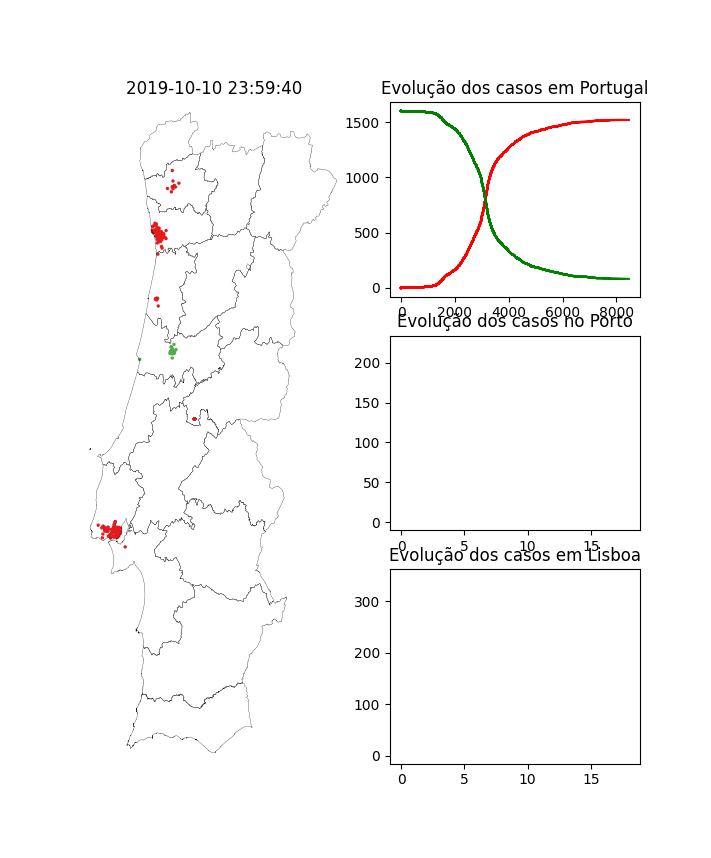

took 28 seconds


In [76]:
%matplotlib notebook

starttime=time.time()

scale=1/3000000
xs_min, xs_max, ys_min, ys_max = -120000, 165000, -310000, 285000
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1
ts_i= 1570665600

fig= plt.figure(figsize=(width_in_inches*scale +3 , height_in_inches*scale)) 

gs = gridspec.GridSpec(3, 2)

pt_map1 = plt.subplot(gs[0:3, 0])
pt_map1.axis('off')
pt_map1.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))

portugal1 = plt.subplot(gs[0, 1])
portugal1.set_title("Evolução dos casos em Portugal")

porto = plt.subplot(gs[1, 1])
porto.set_title("Evolução dos casos no Porto")

lisboa = plt.subplot(gs[2, 1])
lisboa.set_title("Evolução dos casos em Lisboa")

fig.add_subplot(pt_map1) 
fig.add_subplot(portugal1) 
fig.add_subplot(porto) 
fig.add_subplot(lisboa)


query = '''
            SELECT distrito, st_union(proj_boundary) 
            FROM cont_aad_caop2018 
            GROUP BY distrito
        '''

cursor_psql.execute(query)
results = cursor_psql.fetchall()
xs, ys = [],[]

for row in results:
    geom = row[1]
    if type(geom) is MultiPolygon:
        for pol in geom:
            xys = pol[0].coords
            xs, ys = [],[]
            for (x,y) in xys:
                xs.append(x)
                ys.append(y)
            pt_map1.plot(xs,ys,color='black',lw='0.2')
    if type(geom) is Polygon:
        xys = geom[0].coords
        xs, ys = [],[]
        for (x,y) in xys:
            xs.append(x)
            ys.append(y)
        pt_map1.plot(xs,ys,color='black',lw='0.2')
        

green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

colors1, colors2 = np.full(half,green), np.full(rest,red)

colors = [*colors1,*colors2]

xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

scat = pt_map1.scatter(xx,yy,c=colors,s=2, cmap=mpl.cm.Set1)


def animate(i, color_data, scat, n_porto, n_lisboa, histx, histy, histy_ninf,x_horas):
    pt_map1.set_title(datetime.datetime.utcfromtimestamp(ts_i+i*10))
    
    if(i%180==0):

        portugal1.plot(histx[i],histy[i],color='red')
        portugal1.plot(histx[i],histy_ninf[i],color='green')
    if(i%360==0): #de hora a hora, nao esta a funcionar direito
        #porto.plot(x_horas[i],n_porto[i],color='blue') 
        #lisboa.plot(x_horas[i],n_lisboa[i],color='orange')
        pass
    scat.set_array(color_data[i])
    scat.set_offsets(OFFSETS[i])

    
anim = FuncAnimation(fig, animate, interval=10, frames=len(OFFSETS)-1, repeat = False, fargs=(infected,scat,n_porto,n_lisboa, histx, histy, histy_ninf, x_horas))

plt.show()

if DEBUG: print("took %d seconds" % (time.time()-starttime))
    
    
    



# algumas tarefas que me fui lembrando

- Melhorar o código em geral, corrigir os bugs na parte de mostrar os histogramas hora a hora dos infectados no porto e em lisboa, corrigir as proporções do mapa de portugal
* Animação dos poligonos à volta dos infectados no porto, em lisboa e no pais. actualizar o gráfico com a área desses poligonos, ou assim
* Animação "on the fly", ir gerando a epidemia e mostrar os dados "em tempo real", com os critérios de distancia e probabilidade de infecao a poderem ser fornecidos pelo utilizador
* Permitir escolher um concelho e ver a animação apenas nesse concelho, assim como o histograma com o numero dos infectados apenas desse concelho
* Incorporar dados do google maps
* Simular uma epidemia em que após x tempo os taxis recuperam, tornam-se imunes, deixam de contaminar e mudam para outra cor. adicionar ao histograma o numero de recuperados